<a href="https://colab.research.google.com/github/Witcape/finetune_stable_diffusion/blob/main/pokemon_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tune Stable Diffusion

Fine tuning Stable Diffusion on Pokemon,
for more details see the [Lambda Labs examples repo](https://github.com/LambdaLabsML/examples).

We recommend using a multi-GPU machine, for example an instance from [Lambda GPU Cloud](https://lambdalabs.com/service/gpu-cloud). If running on Colab this notebook is likely to need a GPU with >16GB of VRAM and a runtime with high RAM, which will almost certainly need Colab Pro or Pro+. (If you get errors suchs as `Killed` or `CUDA out of memory` then one of these is not sufficient)

In [1]:
!git clone https://github.com/justinpinkney/stable-diffusion.git
%cd stable-diffusion
!pip install --upgrade pip
!pip install -r requirements.txt

!pip install --upgrade keras # on lambda stack we need to upgrade keras
!pip uninstall -y torchtext # on colab we need to remove torchtext

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 1755, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1755 (delta 3), reused 1 (delta 0), pack-reused 1747
Receiving objects: 100% (1755/1755), 73.93 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (1082/1082), done.
/content/stable-diffusion
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers (from -r requirements.txt (line 23))
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Running command git clone --filter=blob:none --quiet h

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0


In [2]:
!nvidia-smi

Mon Feb  5 16:54:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/logo-wizard___parquet/logo-wizard--modern-logo-dataset-ae3918239c4e55f4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


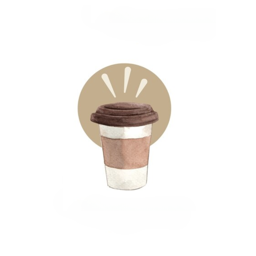

"a logo of coffee shop, take-away coffee cardboard glass with white and brown stripes and dark brown lid, coffee circle with three cream drops, white background, brown foreground, minimalism, modern"


In [3]:
# Check the dataset
from datasets import load_dataset
ds = load_dataset("logo-wizard/modern-logo-dataset", split="train")
sample = ds[0]
display(sample["image"].resize((256, 256)))
print(sample["text"])

To get the weights you need to you'll need to [go to the model card](https://huggingface.co/CompVis/stable-diffusion-v1-4-original), read the license and tick the checkbox if you agree.

In [4]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True)

sd-v1-4-full-ema.ckpt:   0%|          | 0.00/7.70G [00:00<?, ?B/s]

Set your parameters below depending on your GPU setup, the settings below were used for training on a 2xA6000 machine, (the A6000 has 48GB of VRAM). On this set up good results are achieved in around 6 hours.

You can make up for using smaller batches or fewer gpus by accumulating batches:

`total batch size = batach size * n gpus * accumulate batches`

In [6]:
# 2xA6000:
BATCH_SIZE = 4
N_GPUS = 1
ACCUMULATE_BATCHES = 1

gpu_list = ",".join((str(x) for x in range(N_GPUS)))
print(f"Using GPUs: {gpu_list}")

Using GPUs: 0


In [8]:
gpu_list

'0'

In [17]:
# Run training
!(python main.py \
    -t \
    --base configs/stable-diffusion/logo.yaml \
    --gpus "$gpu_list" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
    data.params.validation.params.n_gpus="$NUM_GPUS" \
)

usage: main.py [-h] [--finetune_from [FINETUNE_FROM]] [-n [NAME]] [-r [RESUME]]
               [-b [base_config.yaml ...]] [-t [TRAIN]] [--no-test [NO_TEST]] [-p PROJECT]
               [-d [DEBUG]] [-s SEED] [-f POSTFIX] [-l LOGDIR] [--scale_lr [SCALE_LR]]
               [--logger [LOGGER]] [--checkpoint_callback [CHECKPOINT_CALLBACK]]
               [--default_root_dir DEFAULT_ROOT_DIR] [--gradient_clip_val GRADIENT_CLIP_VAL]
               [--gradient_clip_algorithm GRADIENT_CLIP_ALGORITHM]
               [--process_position PROCESS_POSITION] [--num_nodes NUM_NODES]
               [--num_processes NUM_PROCESSES] [--devices DEVICES] [--gpus GPUS]
               [--auto_select_gpus [AUTO_SELECT_GPUS]] [--tpu_cores TPU_CORES] [--ipus IPUS]
               [--log_gpu_memory LOG_GPU_MEMORY]
               [--progress_bar_refresh_rate PROGRESS_BAR_REFRESH_RATE]
               [--overfit_batches OVERFIT_BATCHES] [--track_grad_norm TRACK_GRAD_NORM]
               [--check_val_every_n_epoch C

In [18]:
!(python scripts/txt2img.py \
    --prompt 'A team named, "Dragon Coders"' \
    --outdir '/content/Final_logos' \
    --H 512 --W 512 \
    --n_samples 4 \
    --config 'configs/stable-diffusion/logo.yaml' \
    --ckpt '/content/Final_logos/Checkpoints')

Global seed set to 42
Traceback (most recent call last):
  File "/content/stable-diffusion/scripts/txt2img.py", line 285, in <module>
    main()
  File "/content/stable-diffusion/scripts/txt2img.py", line 193, in main
    config = OmegaConf.load(f"{opt.config}")
  File "/usr/local/lib/python3.10/dist-packages/omegaconf/omegaconf.py", line 184, in load
    obj = yaml.load(f, Loader=get_yaml_loader())
  File "/usr/local/lib/python3.10/dist-packages/yaml/__init__.py", line 81, in load
    return loader.get_single_data()
  File "/usr/local/lib/python3.10/dist-packages/yaml/constructor.py", line 49, in get_single_data
    node = self.get_single_node()
  File "/usr/local/lib/python3.10/dist-packages/yaml/composer.py", line 36, in get_single_node
    document = self.compose_document()
  File "/usr/local/lib/python3.10/dist-packages/yaml/composer.py", line 55, in compose_document
    node = self.compose_node(None, None)
  File "/usr/local/lib/python3.10/dist-packages/yaml/composer.py", line 84